# SIDO-low-pass-filter
Last update: 12 Feb 2024  

![SIDO low pass filter](SIDO-low-pass-filter.png){#fig-SIDO-low-pass-filter}  

<!--
## Abstract {.unnumbered}
The circuit analyzed is from an [electronics stackexchange](https://electronics.stackexchange.com/) question linked [here](https://electronics.stackexchange.com/questions/682389/transfer-function-of-the-below-circuit), where the use asked for help to determine the transfer function. The circuit appears to be a low pass filter for the input to some following device.  
-->
## Introduction
The circuit shown in @fig-SIDO-low-pass-filter, is from an [electronics stackexchange](https://electronics.stackexchange.com/) question, where @user349644 asks for help in determining the transfer function of the circuit. The circuit appears to be a low pass filter for the differential input to a following device. An interesting response to the question was provided by @user347817, who has provided some interesting solutions to other circuit analysis questions. Usually his solutions are in the from of an image captured from a MathCAD type program consisting of equations, diagrams and plots. 

## Circuit description
The circuit has nine branches, five nodes and was interned into LTSpice in order to capture the schematic and generate the netlist. 

## Circuit analysis
The following analysis was performed.

- solve network equations for the transfer function
- pole, zero plot
- frequency response plot
- step and impusle response
- group delay

The net list for the filter is:
```
V1 1 0 1
C1 1 0 2.2n
C2 4 5 330p
C3 2 3 100p
R1 1 0 100k
R2 4 1 4.7k
R3 5 0 4.7k
R4 2 4 10k
R5 3 5 10k
```

The following Python modules are used.

In [42]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Load the netlist
The netlist generated by LTSpice is pasted into the cell below and some edits were made to remove the inductor series resistance and the independent sources are set to their DC values.

In [44]:
net_list = '''
V1 1 0 1
C1 1 0 2.2e-9
C2 4 5 330e-12
C3 2 3 100e-12
R1 1 0 100e3
R2 4 1 4.7e3
R3 5 0 4.7e3
R4 2 4 10e3
R5 3 5 10e3
'''

Generate the network equations.

In [45]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [47]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{2}} = 0$<br>$- C_{3} s v_{3} + v_{2} \left(C_{3} s + \frac{1}{R_{4}}\right) - \frac{v_{4}}{R_{4}} = 0$<br>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{5}}\right) - \frac{v_{5}}{R_{5}} = 0$<br>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{4}} + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{4}} - \frac{v_{1}}{R_{2}} = 0$<br>$- C_{2} s v_{4} + v_{5} \left(C_{2} s + \frac{1}{R_{5}} + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{5}} = 0$<br>$v_{1} = V_{1}$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [48]:
NE_sym

⎡              ⎛       1    1 ⎞   v₄     ⎤       
⎢    I_V1 + v₁⋅⎜C₁⋅s + ── + ──⎟ - ──     ⎥       
⎢              ⎝       R₂   R₁⎠   R₂     ⎥       
⎢                                        ⎥       
⎢                   ⎛       1 ⎞   v₄     ⎥       
⎢     -C₃⋅s⋅v₃ + v₂⋅⎜C₃⋅s + ──⎟ - ──     ⎥   ⎡0 ⎤
⎢                   ⎝       R₄⎠   R₄     ⎥   ⎢  ⎥
⎢                                        ⎥   ⎢0 ⎥
⎢                   ⎛       1 ⎞   v₅     ⎥   ⎢  ⎥
⎢     -C₃⋅s⋅v₂ + v₃⋅⎜C₃⋅s + ──⎟ - ──     ⎥   ⎢0 ⎥
⎢                   ⎝       R₅⎠   R₅     ⎥ = ⎢  ⎥
⎢                                        ⎥   ⎢0 ⎥
⎢              ⎛       1    1 ⎞   v₂   v₁⎥   ⎢  ⎥
⎢-C₂⋅s⋅v₅ + v₄⋅⎜C₂⋅s + ── + ──⎟ - ── - ──⎥   ⎢0 ⎥
⎢              ⎝       R₄   R₂⎠   R₄   R₂⎥   ⎢  ⎥
⎢                                        ⎥   ⎣V₁⎦
⎢                ⎛       1    1 ⎞   v₃   ⎥       
⎢  -C₂⋅s⋅v₄ + v₅⋅⎜C₂⋅s + ── + ──⎟ - ──   ⎥       
⎢                ⎝       R₅   R₃⎠   R₅   ⎥       
⎢                                        ⎥       


The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [49]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Built a dictionary of element values.

In [50]:
element_values = SymMNA.get_part_values(network_df)
element_values

Generate the symbolic solution

In [51]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [52]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{5} V_{1} s + V_{1}}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{3} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{5} V_{1} s}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{4} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{4} V_{1} s + C_{3} R_{5} V_{1} s + V_{1}}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{5} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$I_{V1} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{4} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{2} R_{5} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{3} R_{4} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{3} R_{5} V_{1} s^{3} - C_{1} C_{2} R_{1} R_{2} V_{1} s^{2} - C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{2} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{4} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{5} V_{1} s^{2} - C_{1} R_{1} V_{1} s - C_{2} C_{3} R_{1} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{1} R_{5} V_{1} s^{2} - C_{2} C_{3} R_{2} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{2} R_{5} V_{1} s^{2} - C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} - C_{2} R_{1} V_{1} s - C_{2} R_{2} V_{1} s - C_{2} R_{3} V_{1} s - C_{3} R_{1} V_{1} s - C_{3} R_{2} V_{1} s - C_{3} R_{3} V_{1} s - C_{3} R_{4} V_{1} s - C_{3} R_{5} V_{1} s - V_{1}}{C_{2} C_{3} R_{1} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{1} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{1} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{1} R_{3} R_{5} s^{2} + C_{2} R_{1} R_{2} s + C_{2} R_{1} R_{3} s + C_{3} R_{1} R_{2} s + C_{3} R_{1} R_{3} s + C_{3} R_{1} R_{4} s + C_{3} R_{1} R_{5} s + R_{1}}$<br>

Transfer function

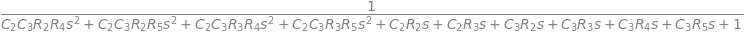

In [53]:
H_sym = ((U_sym[v2]-U_sym[v3])/U_sym[v1]).nsimplify().simplify().expand().together()
H_sym

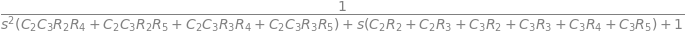

In [54]:
cancel(H_sym,s)

In [55]:
H_sym_num, H_sym_denom = fraction(H_sym) #returns numerator and denominator

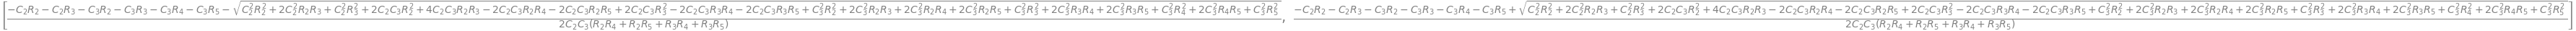

In [56]:
solve(H_sym_denom,s)

### Numerical solution

In [57]:
NE = NE_sym.subs(element_values)
NE

⎡           I_V1 + v₁⋅(2.2e-9⋅s + 0.000222765957446809) - 0.000212765957446809
⎢                                                                             
⎢                    -1.0e-10⋅s⋅v₃ + v₂⋅(1.0e-10⋅s + 0.0001) - 0.0001⋅v₄      
⎢                                                                             
⎢                    -1.0e-10⋅s⋅v₂ + v₃⋅(1.0e-10⋅s + 0.0001) - 0.0001⋅v₅      
⎢                                                                             
⎢-3.3e-10⋅s⋅v₅ - 0.000212765957446809⋅v₁ - 0.0001⋅v₂ + v₄⋅(3.3e-10⋅s + 0.00031
⎢                                                                             
⎢             -3.3e-10⋅s⋅v₄ - 0.0001⋅v₃ + v₅⋅(3.3e-10⋅s + 0.000312765957446809
⎢                                                                             
⎣                                            v₁                               

⋅v₄           ⎤   ⎡ 0 ⎤
              ⎥   ⎢   ⎥
              ⎥   ⎢ 0 ⎥
              ⎥   ⎢   ⎥
              ⎥   ⎢ 0 ⎥
          

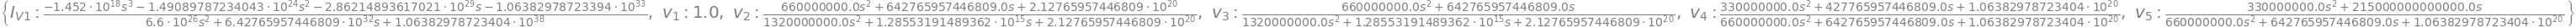

In [58]:
U = solve(NE,X)
U

In [59]:
temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = 1.0$<br>$v_{2} = \frac{660000000.0 s^{2} + 642765957446809.0 s + 2.12765957446809 \cdot 10^{20}}{1320000000.0 s^{2} + 1.28553191489362 \cdot 10^{15} s + 2.12765957446809 \cdot 10^{20}}$<br>$v_{3} = \frac{660000000.0 s^{2} + 642765957446809.0 s}{1320000000.0 s^{2} + 1.28553191489362 \cdot 10^{15} s + 2.12765957446809 \cdot 10^{20}}$<br>$v_{4} = \frac{330000000.0 s^{2} + 427765957446809.0 s + 1.06382978723404 \cdot 10^{20}}{660000000.0 s^{2} + 642765957446809.0 s + 1.06382978723404 \cdot 10^{20}}$<br>$v_{5} = \frac{330000000.0 s^{2} + 215000000000000.0 s}{660000000.0 s^{2} + 642765957446809.0 s + 1.06382978723404 \cdot 10^{20}}$<br>$I_{V1} = \frac{- 1.452 \cdot 10^{18} s^{3} - 1.49089787234043 \cdot 10^{24} s^{2} - 2.86214893617021 \cdot 10^{29} s - 1.06382978723394 \cdot 10^{33}}{6.6 \cdot 10^{26} s^{2} + 6.42765957446809 \cdot 10^{32} s + 1.06382978723404 \cdot 10^{38}}$<br>

In [60]:
H = ((U[v2]-U[v3])/U[v1]).nsimplify().simplify().expand().together()
H

#### Convert transfer function to SciPy system
In this section we convert the SymPy equations into Numpy format.  

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [61]:
H_num, H_denom = fraction(H) #returns numerator and denominator

The SciPy function, TransferFunction, represents the system as the continuous-time transfer function and takes as inputs the coeeficients of the numerator and denominator polynominals.

In [62]:
# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys = signal.TransferFunction(a,b)

### Poles and zeros of the low pass transfer function
The poles and zeros of the transfer function can easly be obtained with the following code:

In [63]:
sys_zeros = np.roots(sys.num)
sys_poles = np.roots(sys.den)

#### Low pass filter pole zero plot
The poles and zeros of the preamp transfer function are plotted.

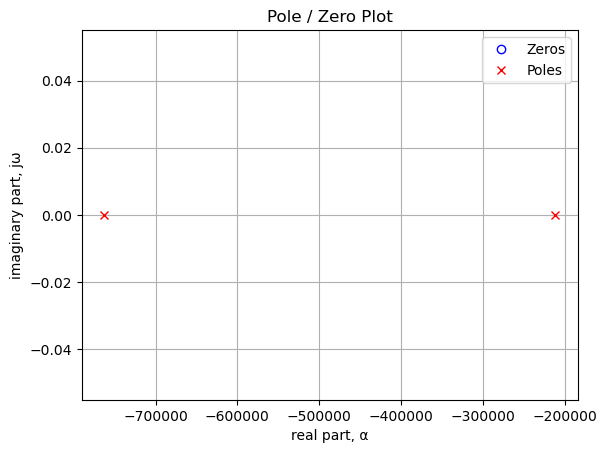

In [64]:
plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=1)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane. The units are in radian frequency.

Printing these values in Hz.

In [65]:
print('number of zeros: {:d}'.format(len(sys_zeros)))
for i in sys_zeros:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of zeros: 0


In [66]:
print('number of poles: {:d}'.format(len(sys_poles)))
for i in sys_poles:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of poles: 2
-121,354.74 Hz
-33,644.32 Hz


### Bode plot
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter. In electrical engineering, a [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) is a graph of the frequency response of a system. It is usually a combination of the magnitude (usually in decibels) of the frequency response and the phase shift. As originally conceived by Hendrik Wade Bode in the 1930s, the plot is an asymptotic approximation of the frequency response, using straight line segments. Bode plots are used to assess the stability of systems by finding the gain and phase margins.

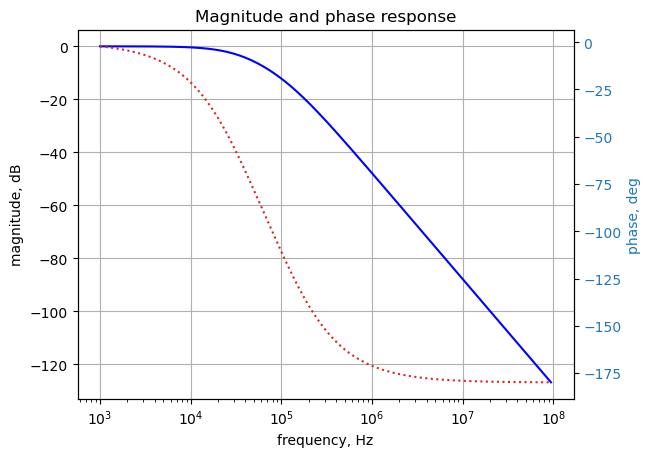

In [67]:
x = np.logspace(3, 8, 200, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(sys, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

### Filter impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

The [impulse](https://en.wikipedia.org/wiki/Impulse_response) and [step response](https://en.wikipedia.org/wiki/Step_response) of the filter are plotted below. Any linear, time-invariant is completely characterized by its impulse response. The transfer function is the Laplace transform of the impulse response. The impulse response defines the response of a linear time-invariant system for all frequencies.

In electronic engineering and control theory, step response is the time behavior of the outputs of a general system when its inputs change from zero to one in a very short time.

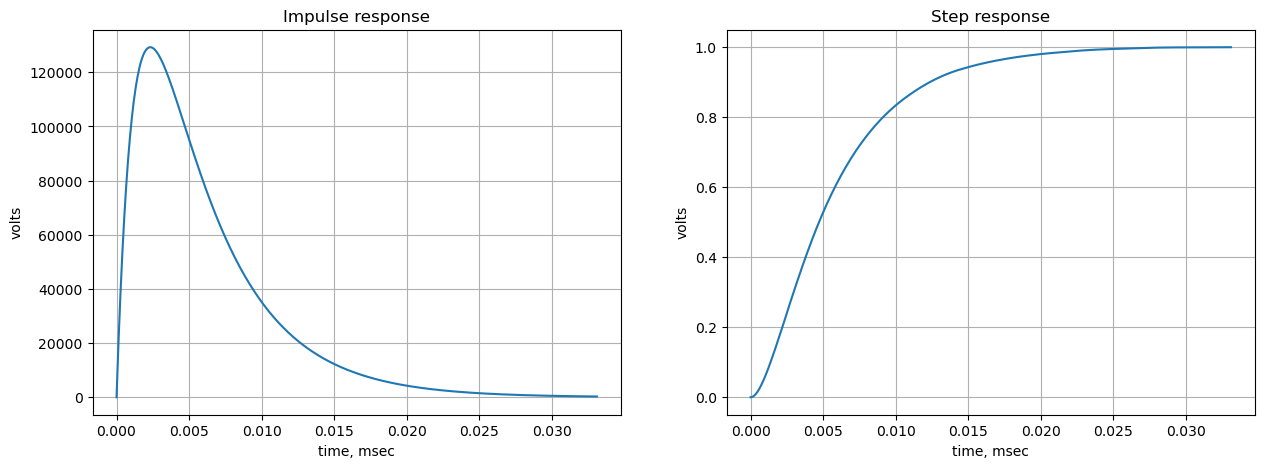

In [68]:
plt.subplots(1,2,figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# show plot
plt.show()

### Low pass filter group delay
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

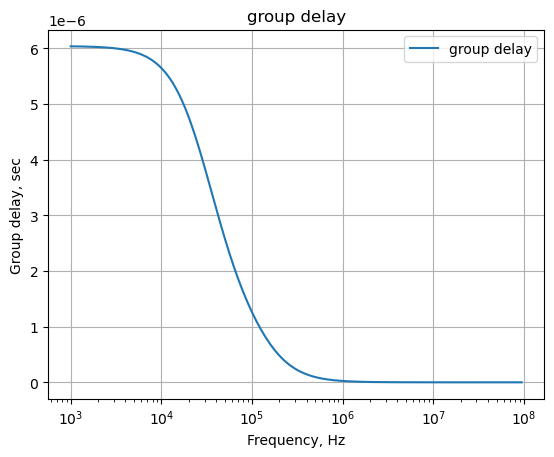

In [69]:
#w_preamp, mag_preamp, phase_preamp = bp_sys.bode(w=x_axis_range)

plt.title('group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase*np.pi/180)/np.gradient(w),'-',label='group delay')

plt.ylabel('Group delay, sec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()